In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier , RandomForestClassifier


%matplotlib inline
plt.rcParams["figure.figsize"] = (14,7)

warnings.filterwarnings('ignore')

# Data Ingest

## Abbrevations and features:

- spo2 (int): The patient's oxygen saturation level
- hr (int): The patient's heart rate
- sys (int): The patient's systolic blood pressure
- dia (int): The patient's diastolic blood pressure
- rr (int): The patient's respiratory rate
- monitor_alarm: Whether an alarm has been triggered by the given function
- doctor_alarm: Whether an alarm has been confirmed as "relevant" by the doctor


In [2]:
df = pd.read_csv('icu_vitals.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4008 entries, 0 to 4007
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   hr             4008 non-null   int64
 1   rr             4008 non-null   int64
 2   spo2           4008 non-null   int64
 3   sys            4008 non-null   int64
 4   dia            4008 non-null   int64
 5   monitor_alarm  4008 non-null   bool 
 6   doctor_alarm   4008 non-null   bool 
dtypes: bool(2), int64(5)
memory usage: 164.5 KB


In [3]:
df.head()

,hr,rr,spo2,sys,dia,monitor_alarm,doctor_alarm
0,94,15,100,163,81,False,False
1,88,15,99,128,62,False,False
2,82,17,100,103,50,False,False
3,89,18,100,139,83,False,False
4,95,26,100,153,73,False,False


## Analysis

In [4]:
#has no missing values
df.isnull().sum()

hr               0
rr               0
spo2             0
sys              0
dia              0
monitor_alarm    0
doctor_alarm     0
dtype: int64

In [5]:
#has no duplicates
print(f'Before drop_duplicates(): {df.shape}')
df = df.drop_duplicates()
print(f'After drop_duplicates(): {df.shape}')

Before drop_duplicates(): (4008, 7)
After drop_duplicates(): (4008, 7)


In [6]:
df.describe()

,hr,rr,spo2,sys,dia
count,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000
mean,86.994012,20.400449,97.417665,118.893713,61.085828
std,16.495538,5.998675,3.103362,22.849497,13.873942
min,35.000000,0.000000,34.000000,47.000000,17.000000
25%,76.000000,16.000000,96.000000,101.000000,52.000000
50%,86.000000,20.000000,98.000000,116.000000,60.000000
75%,98.000000,24.000000,100.000000,135.000000,70.000000
max,149.000000,47.000000,100.000000,201.000000,142.000000


Mean and Median are close to each other in all cases. In conjunction with neither missing values occuring, nor duplicates, the assumption goes with already cleansed and prepared data, ready for consumption. 

<AxesSubplot:>

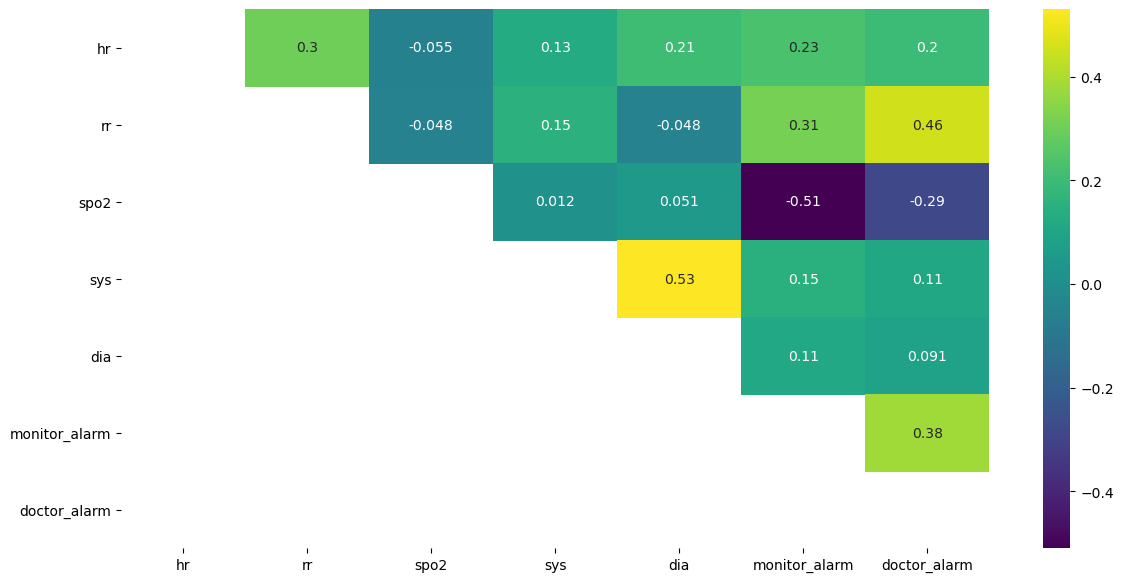

In [7]:
sns.heatmap(
    df.corr(),
    mask=np.tri(len(df.columns)),
    cmap='viridis',
    annot=True
)

We do see:

Weak or even neglectable linear correlation between 
- spo2 and hr, rr, sys, dia
- hr and sys, dia and both alarm types

But stronger correlations between
- spo2 and both alarm types
- sys and dia

A value of $0.38$ between both alarm types indicates an often occuring disagreement, confirming the already known potential with false alarms.

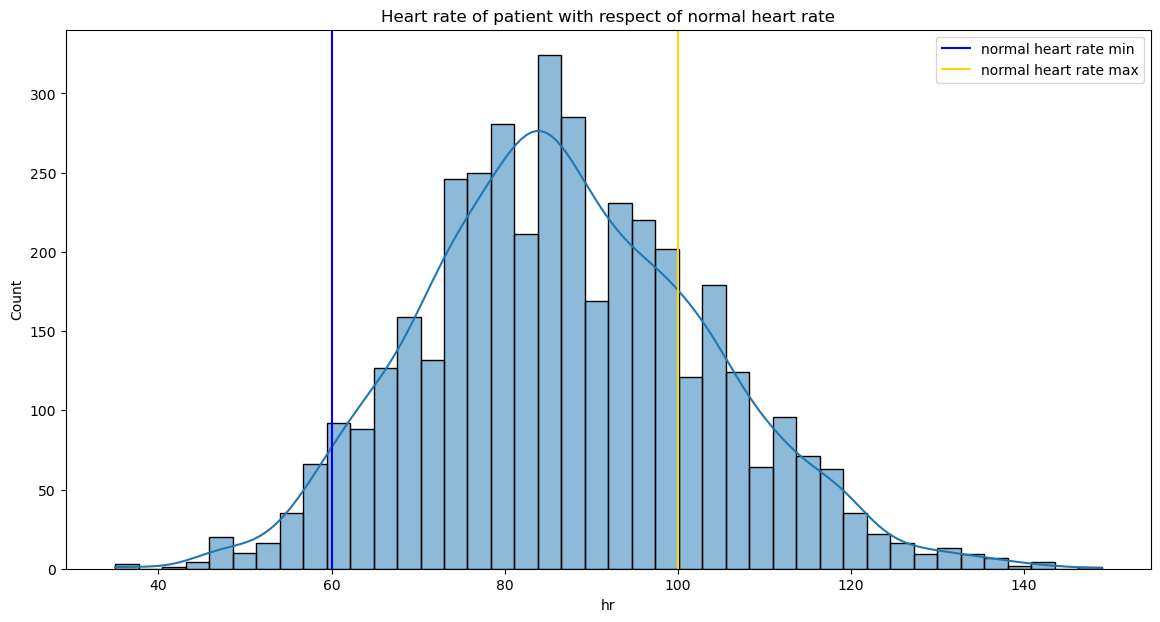

In [8]:
ax = sns.histplot(data=df, x='hr', kde=True)
line60 = ax.axvline(x=60, color="blue", label="normal heart rate min")
line100 = ax.axvline(x=100, color="gold", label="normal heart rate max")
ax.set(title= "Heart rate of patient with respect of normal heart rate")
ax.legend()
plt.show()

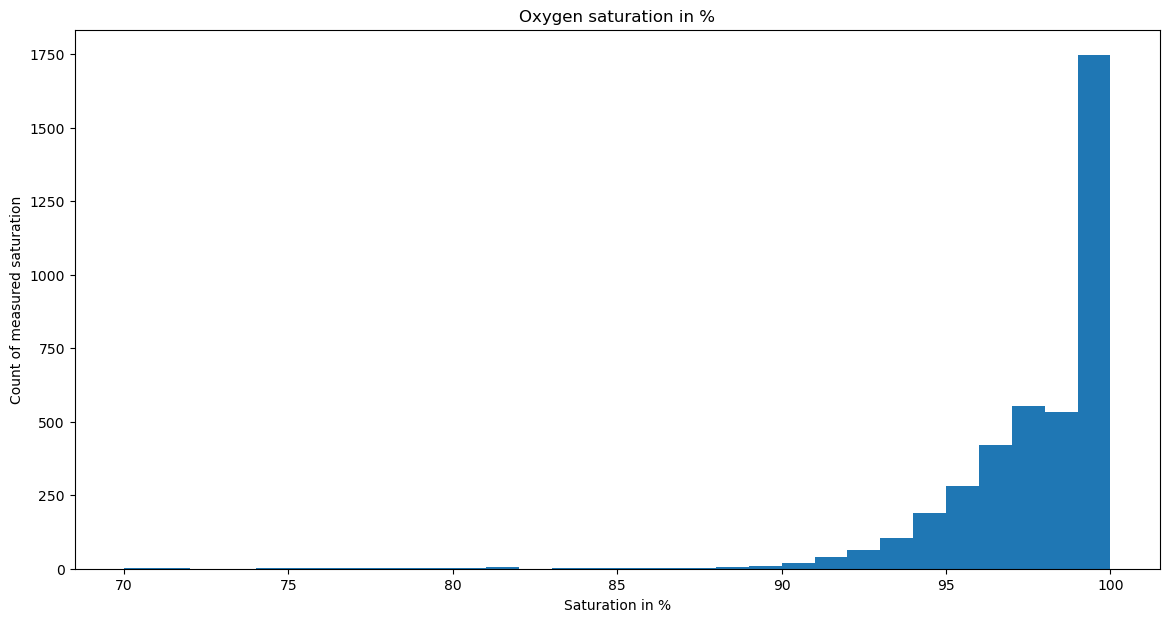

In [9]:
plt.figure(figsize= (14,7))
plt.hist(df['spo2'], bins = 30, range = [70,100] )
plt.xlabel('Saturation in %')
plt.ylabel('Count of measured saturation')
plt.title('Oxygen saturation in %')
plt.show()

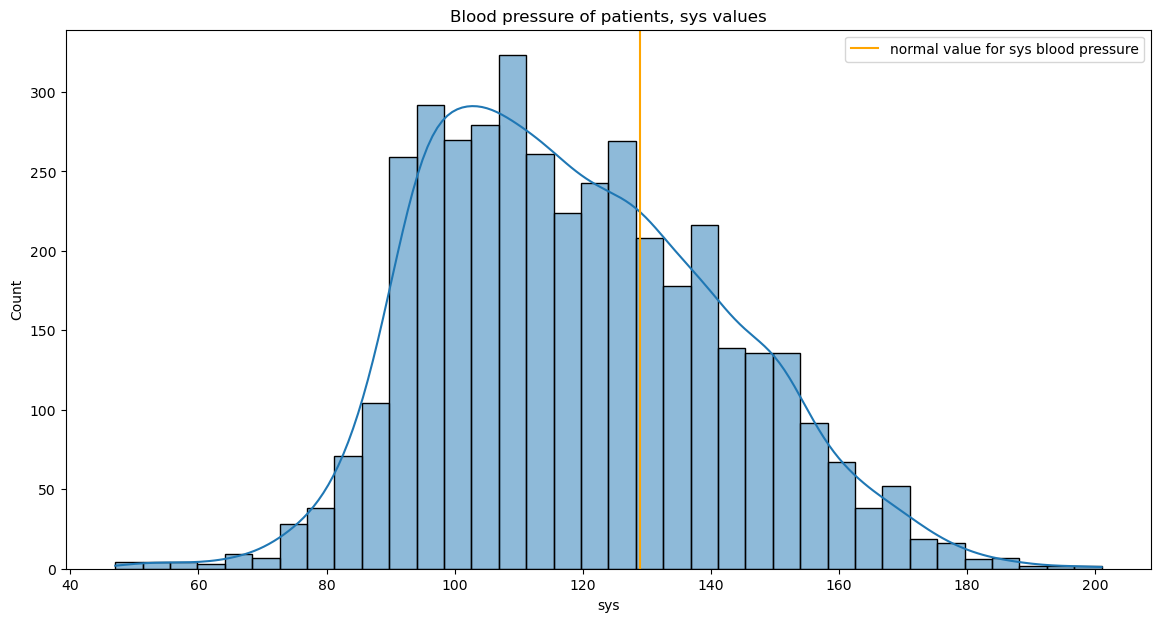

In [10]:
ax = sns.histplot(data=df, x='sys', kde=True)
line129 = ax.axvline(x=129, color="orange", label="normal value for sys blood pressure")
#line98 = ax.axvline(x=98, color="gold", label="normal heart rate max")
ax.set(title= "Blood pressure of patients, sys values")
ax.legend()
plt.show()

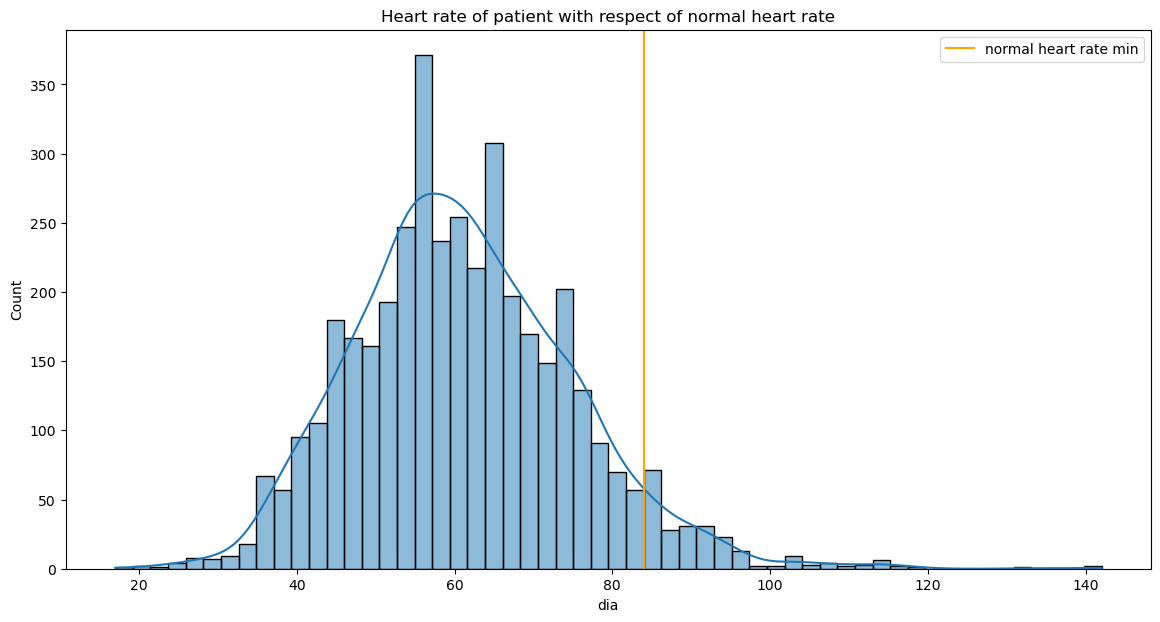

In [11]:
ax = sns.histplot(data=df, x='dia', kde=True)
line84 = ax.axvline(x=84, color="orange", label="normal heart rate min")
#line98 = ax.axvline(x=98, color="gold", label="normal heart rate max")
ax.set(title= "Heart rate of patient with respect of normal heart rate")
ax.legend()
plt.show()

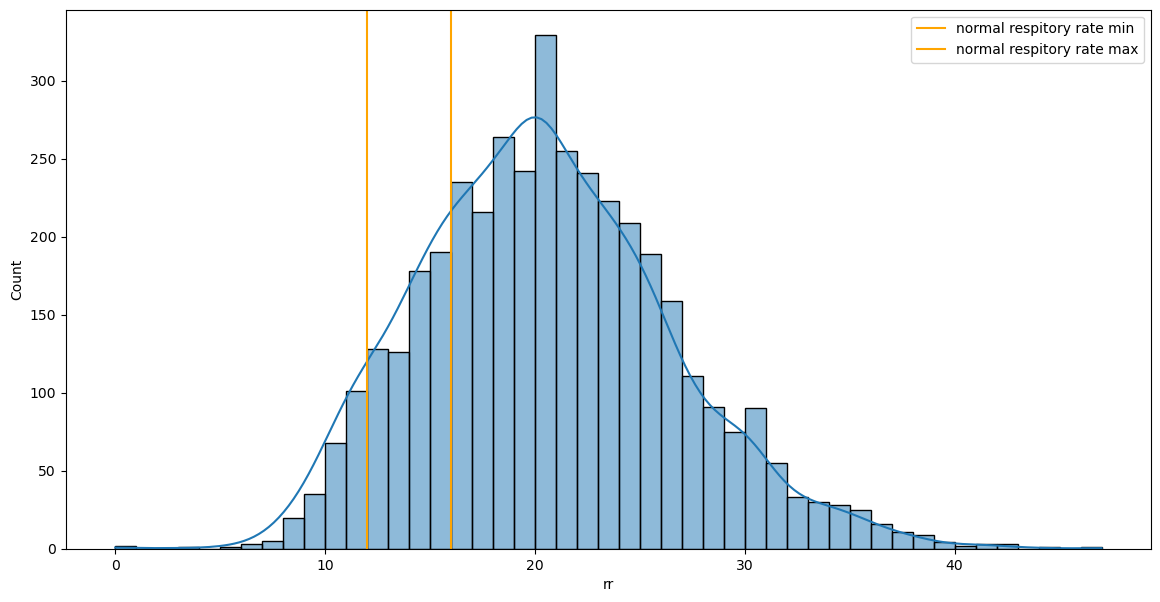

In [12]:
ax = sns.histplot(data=df, x='rr', kde=True)
line12 = ax.axvline(x=12, color="orange", label="normal respitory rate min")
line16 = ax.axvline(x=16, color="orange", label="normal respitory rate max")
#ax.set(title= "Heart rate of patient with respect of normal heart rate")
ax.legend()
plt.show()

### Check the correctness of predefined thresholds for classification prediction 

In [13]:
# Helper function for model evaluation
def calc_conf_matrix_measures (y_test, y_pred, model_name):
    result = {
        'model_name': model_name,
        'precision': precision_score(y_test, y_pred),
        'recall' :  recall_score(y_test, y_pred),
        'accuracy' : accuracy_score(y_test, y_pred),
        'f1score' : f1_score(y_test, y_pred)
    }    
    
    return result

In [14]:
tf_result = calc_conf_matrix_measures(df.doctor_alarm, df.monitor_alarm, 'tuning_factor')

In [15]:
result_df = pd.DataFrame(columns=['model_name','precision','recall','accuracy','f1score'])
result_df = result_df.append([tf_result], ignore_index=True)
result_df

,model_name,precision,recall,accuracy,f1score
0,tuning_factor,0.287472,0.919499,0.670908,0.438006


# Challenger Model 1: Random Forest

In [16]:
# divide dataset between feature and target subsets
feature_col= ['rr','spo2','hr','sys','dia']
X = df[feature_col]
y = df['doctor_alarm']

# Split dataset into training set and test set
# 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=1
) 

In [17]:
# Create Decision Tree classifer object
rfc = RandomForestClassifier(max_depth=2, random_state=0)

# Train Decision Tree Classifer
rfc = rfc.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rfc.predict(X_test)

In [18]:
# Model Evaluation
rf_result = calc_conf_matrix_measures(y_test, y_pred, 'random_forest')
result_df = result_df.append([rf_result], ignore_index=True)
result_df

,model_name,precision,recall,accuracy,f1score
0,tuning_factor,0.287472,0.919499,0.670908,0.438006
1,random_forest,0.952381,0.169492,0.876559,0.287770


# Challenger Model 2: Support vector machine 

In [19]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [20]:
# Model evaluation
svm_result = calc_conf_matrix_measures(y_test,y_pred, 'svm')
result_df = result_df.append(svm_result, ignore_index=True)
result_df

,model_name,precision,recall,accuracy,f1score
0,tuning_factor,0.287472,0.919499,0.670908,0.438006
1,random_forest,0.952381,0.169492,0.876559,0.287770
2,svm,0.851852,0.389831,0.900249,0.534884


# Challenger Model 3: GradientBoostedTree

In [21]:
param_grid = {'loss': ['exponential'],
            'n_estimators' : [100, 200,500],
            'max_depth' : [3,5,7,9],
            'min_samples_split': [2,3,5]
            }
estimator = GradientBoostingClassifier()
sh = GridSearchCV(
    estimator,
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1
)\
    .fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [22]:
clf = sh.best_estimator_
y_pred = clf.predict(X_test)

In [23]:
gbc_result = calc_conf_matrix_measures(y_test, y_pred, 'gbc')
result_df = result_df.append(gbc_result, ignore_index=True)
result_df

,model_name,precision,recall,accuracy,f1score
0,tuning_factor,0.287472,0.919499,0.670908,0.438006
1,random_forest,0.952381,0.169492,0.876559,0.287770
2,svm,0.851852,0.389831,0.900249,0.534884
3,gbc,0.857143,0.661017,0.933915,0.746411


# Performance comparison between initial and GradientBoostedTree model

In [24]:
### Results in detail again compared to tuning factor (== tf_result)

calc_conf_matrix_measures(df.doctor_alarm, df.monitor_alarm, 'gbc')

print(f""" \
    PRECISION:: OLD: {tf_result['precision']:,.2f} || NEW: {gbc_result['precision']:,.2f} -> reduction of false alarms by 57% \n\
    recall:: OLD: {tf_result['recall']:,.2f} || NEW: {gbc_result['recall']:,.2f} -> missing 26% additional of true alarms (ethical question?) \n\
    accuracy:: OLD: {tf_result['accuracy']:,.2f} || NEW: {gbc_result['accuracy']:,.2f} -> 26% increase of overall model performance \n\
    f1score:: OLD: {tf_result['f1score']:,.2f} || NEW: {gbc_result['f1score']:,.2f} -> 31% increase of model metric performance \
""")

     PRECISION:: OLD: 0.29 || NEW: 0.86 -> reduction of false alarms by 57% 
    recall:: OLD: 0.92 || NEW: 0.66 -> missing 26% additional of true alarms (ethical question?) 
    accuracy:: OLD: 0.67 || NEW: 0.93 -> 26% increase of overall model performance 
    f1score:: OLD: 0.44 || NEW: 0.75 -> 31% increase of model metric performance 


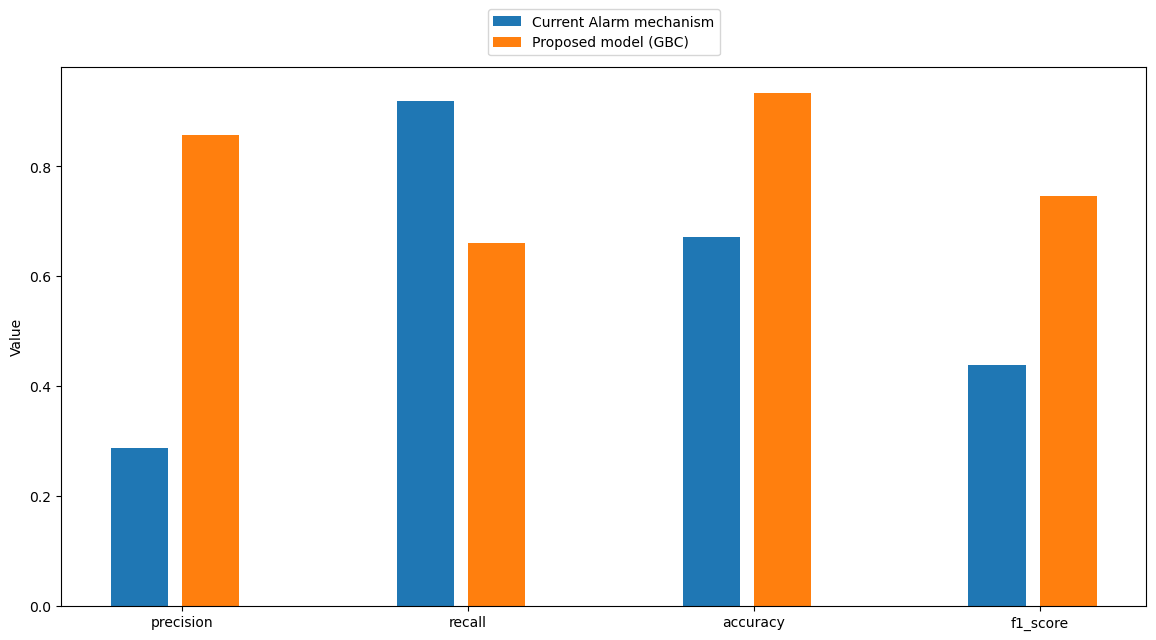

In [25]:
X = ['precision', 'recall', 'accuracy', 'f1_score']
Y = [result_df['precision'][0], result_df['recall'][0], result_df['accuracy'][0], result_df['f1score'][0]]
#Z = [result_df['precision'][1], result_df['recall'][1], result_df['accuracy'][1], result_df['f1score'][1]]
#Z1 = [result_df['precision'][2], result_df['recall'][2], result_df['accuracy'][2], result_df['f1score'][2]]
Z2 = [result_df['precision'][3], result_df['recall'][3], result_df['accuracy'][3], result_df['f1score'][3]]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.25,  Y, width = 0.2 , align='edge', label = 'Current Alarm mechanism')
#plt.bar(X_axis - 0.5, Z, 0.2, align='edge', label = 'random forest')
#plt.bar(X_axis - 0.75, Z1, 0.2, align='edge', label = 'svm')
plt.bar(X_axis ,  Z2, width = 0.2,  align='edge', label = 'Proposed model (GBC)')
 
plt.xticks(X_axis, X)
plt.ylabel("Value")
plt.legend(loc=9, bbox_to_anchor=(0.5, 1.12))
plt.show()

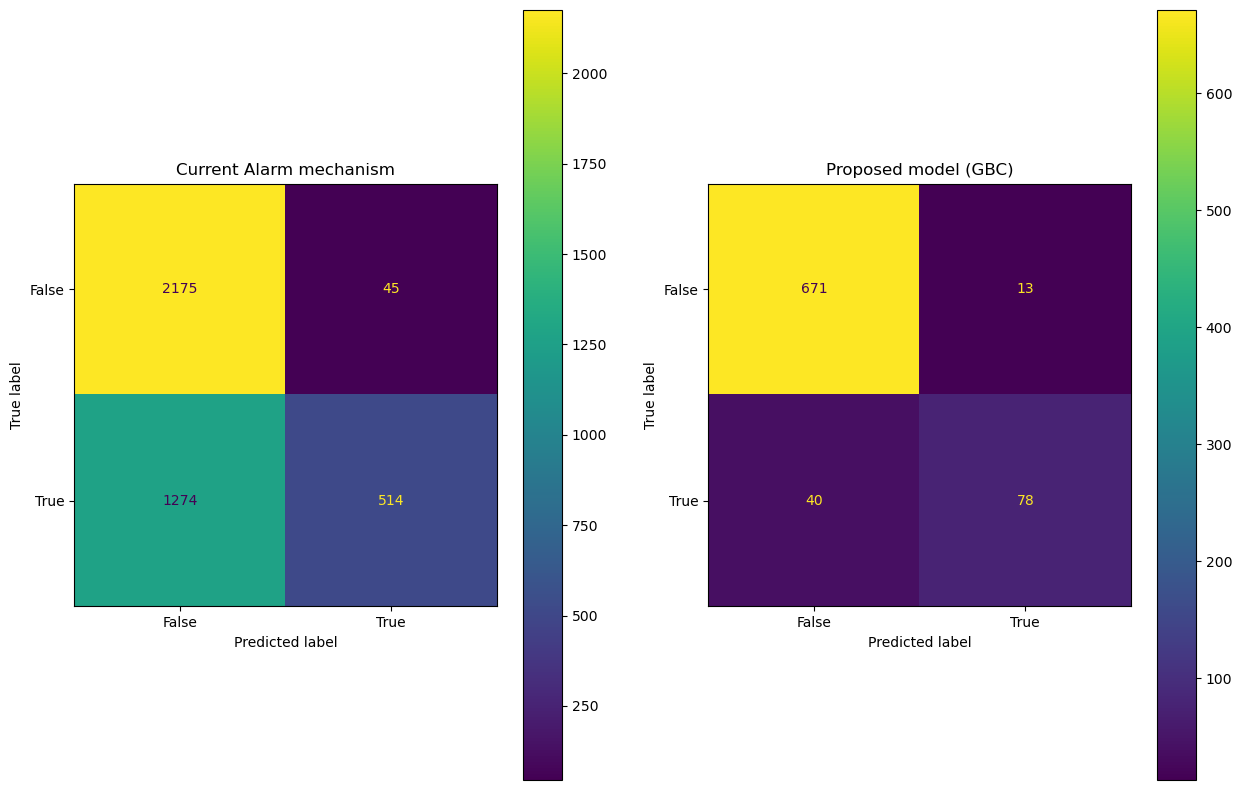

In [26]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,10) )
ax[0].set_title("Current Alarm mechanism")
ax[1].set_title("Proposed model (GBC)")

metrics.ConfusionMatrixDisplay(
confusion_matrix = metrics.confusion_matrix(df.monitor_alarm, df.doctor_alarm), 
display_labels = [False, True]).plot(ax=ax[0])

metrics.ConfusionMatrixDisplay(
confusion_matrix = metrics.confusion_matrix(y_test, y_pred), 
display_labels = [False, True]).plot(ax=ax[1]);

# Business impact 

- ICU: 18 patients
- 100 alarms per patient per day
- 1800 alarms per day per ICU
- from 100 alarms: 29 relevant, 3 missing, 71 irrelevant (false alarm)

That means:
- an ICU patient yields 32 **relevant** alarms per day (in average)
    - out of which 29 are correctly identified as such 
    - three were missed 
    - 71 false alarms triggered 



## Consequences: Detection of missed alarms [recall]

In [27]:
def calc_missed_alarms(recall):
    missed_alarm = int(32* recall)
    missed_alarm_daily = int((32 -missed_alarm)*18)
    
    return missed_alarm_daily

In [28]:
def diff_missed_alarm_daily(recall1,recall2):
    model1_missed_alarm_daily = calc_missed_alarms(recall1)
    model2_missed_alarm_daily = calc_missed_alarms(recall2)
    diff_missed_alarm_daily = model1_missed_alarm_daily/model2_missed_alarm_daily
    
    return diff_missed_alarm_daily,model1_missed_alarm_daily,model2_missed_alarm_daily


In [29]:
# check performance difference between initial model and GBC model
tf_vs_GBC_missed_alarm_daily, tf_missed_alarm_daily, GBC_missed_alarm_daily  = diff_missed_alarm_daily(tf_result['recall'], gbc_result['recall'])
print(f"""\
      With the GBC approach there are {100*tf_vs_GBC_missed_alarm_daily:,.2f} % more missed alarms daily in comparison to initial model.""")

      With the GBC approach there are 27.27 % more missed alarms daily in comparison to initial model.


In [40]:
perc_tf_missed_alarm_daily = 100*(tf_missed_alarm_daily/(32*18))
perc_gbc_missed_alarm_daily = 100*(GBC_missed_alarm_daily/(32*18))
perc_tf_missed_alarm_daily

9.375

Text(0.5, 1.0, 'Missed alarms daily')

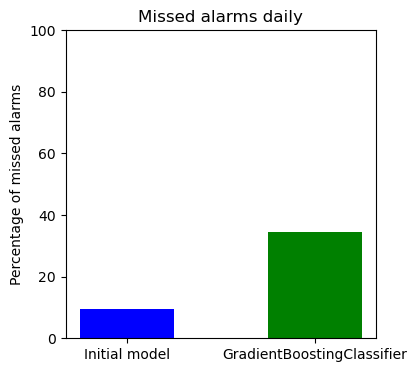

In [54]:
fig, ax  = plt.subplots(figsize=(4,4))
ax.bar([1, 2], [perc_tf_missed_alarm_daily, perc_gbc_missed_alarm_daily],color= ['blue','green'],width=0.5,
       tick_label=['Initial model', 'GradientBoostingClassifier'], align='center')
plt.ylabel('Percentage of missed alarms')
ax.set_ylim([0,100])
plt.title('Missed alarms daily')

## Time investment in false alarms [precision] (Business point of view)

In [55]:
def time_savings_false_alarm_daily(precision1 : float, precision2 : float):


    """
calculate how many hours of hours spend daily on false alarms in model1 and model2 of choice
 and how many hours is saved by the different models"""
    
    
    model1_hours_spend_false_alarm_daily = round((100*(1-precision1) * 2 * 18) / 60, 2)
    model2_hours_spend_false_alarm_daily = round((100*(1-precision2) * 2 * 18) / 60, 2)
    time_savings_false_alarm_daily = model1_hours_spend_false_alarm_daily - model2_hours_spend_false_alarm_daily
    
    return time_savings_false_alarm_daily, model1_hours_spend_false_alarm_daily,model2_hours_spend_false_alarm_daily

In [56]:
def perc_time_saving_FP_daily(M1_hours_spend_FP_daily: float,M2_hours_spend_FP_daily: float):
    """
    calculates the percentage of saved time for false alarm verification between two models"""
    perc_time_saving_FP_daily = round(100*(1-(M2_hours_spend_FP_daily/M1_hours_spend_FP_daily)),2)
    
    return perc_time_saving_FP_daily

In [57]:
# Time spend on FP for initial and GBC model and difference of both
tf_vs_gbc_time_saving_FP, tf_hours_spend_FP_daily, GBC_hours_spend_FP_daily = time_savings_false_alarm_daily(tf_result['precision'],gbc_result['precision'])
TF_vs_GBC_time_saving_FP_daily = perc_time_saving_FP_daily(tf_hours_spend_FP_daily,GBC_hours_spend_FP_daily)
TF_vs_GBC_time_saving_FP_daily
print(f""" 
An expense of {tf_hours_spend_FP_daily} is needed in the initial model
to verify on false alarm. After implementaion of BGC model only {GBC_hours_spend_FP_daily} h is needed to put in false alarms.
Working time is saved by {TF_vs_GBC_time_saving_FP_daily} % with the help of the GBC approach.""")

 
An expense of 42.75 is needed in the initial model
to verify on false alarm. After implementaion of BGC model only 8.57 h is needed to put in false alarms.
Working time is saved by 79.95 % with the help of the GBC approach.


Text(0.5, 1.0, 'Time expenditure on false alarms daily')

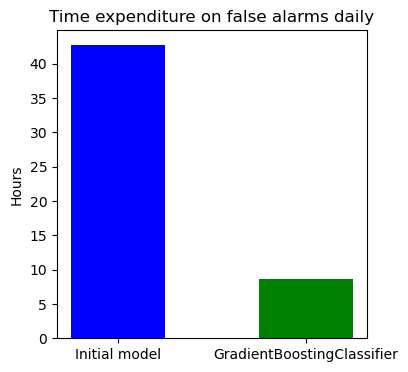

In [58]:
fig, ax  = plt.subplots(figsize=(4,4))
ax.bar([1, 2], [tf_hours_spend_FP_daily, GBC_hours_spend_FP_daily],color= ['blue','green'],width=0.5,
       tick_label=['Initial model', 'GradientBoostingClassifier'], align='center')
plt.ylabel('Hours')
plt.title('Time expenditure on false alarms daily')


Text(0.5, 1.0, 'Overall prediction accuracy')

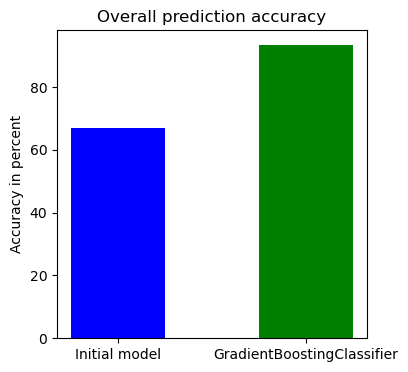

In [60]:
tf_perc_accuracy = round((tf_result['accuracy']*100),2)
GBC_perc_accuracy = round((gbc_result['accuracy']*100),2)
fig, ax  = plt.subplots(figsize=(4,4))
ax.bar([1, 2], [tf_perc_accuracy, GBC_perc_accuracy], color = ['blue','green'],width=0.5,
       tick_label=['Initial model', 'GradientBoostingClassifier'], align='center')
plt.ylabel('Accuracy in percent')
plt.title('Overall prediction accuracy')